In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import norm, probplot, rankdata
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from typing import Tuple, Dict, Optional, Set, List
from scipy.stats import mannwhitneyu

In [2]:
path = 'AB_Testing_Data.csv'

In [3]:
ab_test_df = pd.read_csv(path)

In [4]:
ab_test_df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


### Hypotheses:

- **Null Hypothesis (H₀):** The means or income distributions of the control and test groups do not differ.
- **Alternative Hypothesis (H₁):** The means or income distributions of the control and test groups differ.

In [5]:
ab_test_df = ab_test_df.rename(columns = lambda column_name: column_name.lower())

In [6]:
ab_test_df.shape

(10000, 3)

In [7]:
ab_test_df.dtypes

user_id           int64
variant_name     object
revenue         float64
dtype: object

In [8]:
ab_test_df.nunique()

user_id         6324
variant_name       2
revenue          101
dtype: int64

In [9]:
ab_test_df.isna().sum()

user_id         0
variant_name    0
revenue         0
dtype: int64

In [10]:
ab_test_df['variant_name'].value_counts(normalize=True)

variant_name
variant    0.5016
control    0.4984
Name: proportion, dtype: float64

In [11]:
ab_test_df.groupby('user_id')['variant_name'].nunique().value_counts(normalize=True)

variant_name
1    0.756325
2    0.243675
Name: proportion, dtype: float64

<Axes: >

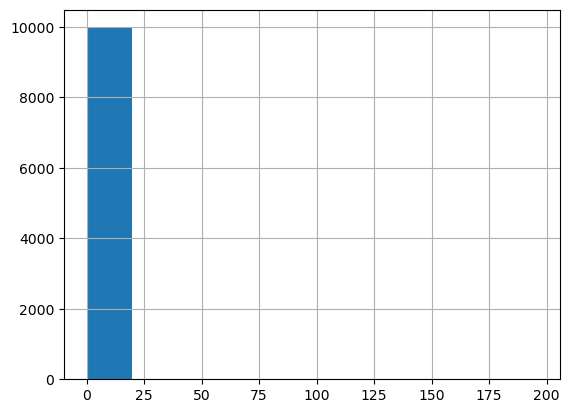

In [12]:
ab_test_df['revenue'].hist()

In [13]:
ab_test_df[ab_test_df.duplicated()]

,user_id,variant_name,revenue
106,7704,control,0.0
195,8406,variant,0.0
224,7042,variant,0.0
302,4409,control,0.0
422,1621,variant,0.0
...,...,...,...
9989,2444,variant,0.0
9993,2400,variant,0.0
9994,3129,control,0.0
9995,1981,control,0.0


In [14]:
ab_df_unique = ab_test_df.drop_duplicates()

In [15]:
ab_df_unique.head()

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [16]:
len(ab_df_unique)

7933

In [17]:
ab_df_unique.groupby('variant_name', as_index =False)\
            .agg({'revenue' : [np.mean, np.std, pd.Series.mode, 'count', np.sum]})

variant_name   revenue                             
                    mean       std mode count     sum
0      control  0.161842  3.367815  0.0  3973  643.00
1      variant  0.088755  1.479239  0.0  3960  351.47

In [18]:
ab_df_unique['revenue'].describe()

count    7933.000000
mean        0.125359
std         2.602527
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: revenue, dtype: float64

In [19]:
control = ab_df_unique.query("variant_name =='control'").reset_index(drop= True)

In [20]:
test = ab_df_unique.query("variant_name =='variant'").reset_index(drop= True)

(0.0, 10.0)

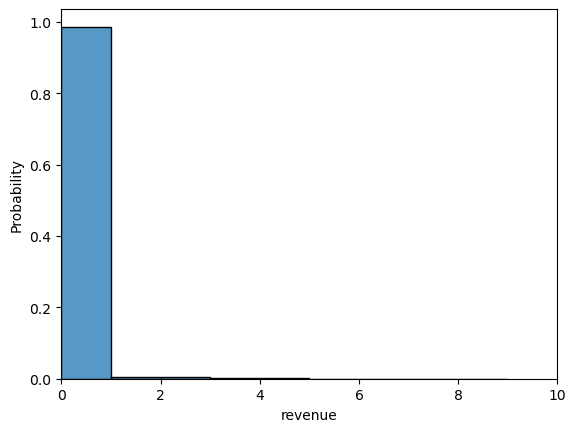

In [21]:
fig = plt.figure()
ax_clicks = fig.add_subplot()
clicks_distr = sns.histplot(control['revenue'],
                            bins=range(0, 10),
                            kde=False,
                            ax=ax_clicks,
                            stat='probability')
ax_clicks.set_xlim((0, 10))

(0.0, 10.0)

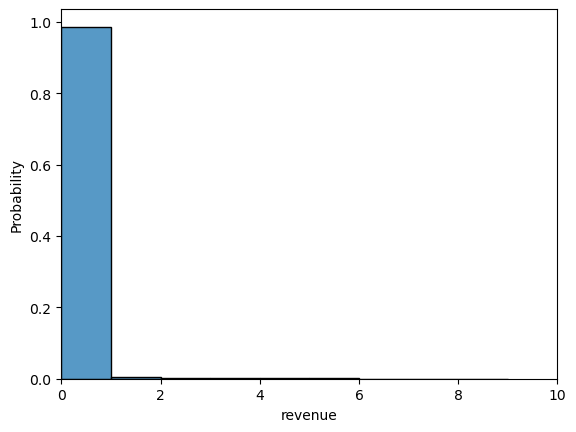

In [22]:
fig = plt.figure()
ax_clicks = fig.add_subplot()
clicks_distr = sns.histplot(test['revenue'], 
                            bins=range(0, 10),
                            kde=False,
                            ax=ax_clicks,
                            stat='probability')
ax_clicks.set_xlim((0, 10))

In [23]:
control_revenue = ab_df_unique[ab_df_unique['variant_name'] == 'control']['revenue']
test_revenue = ab_df_unique[ab_df_unique['variant_name'] == 'variant']['revenue']

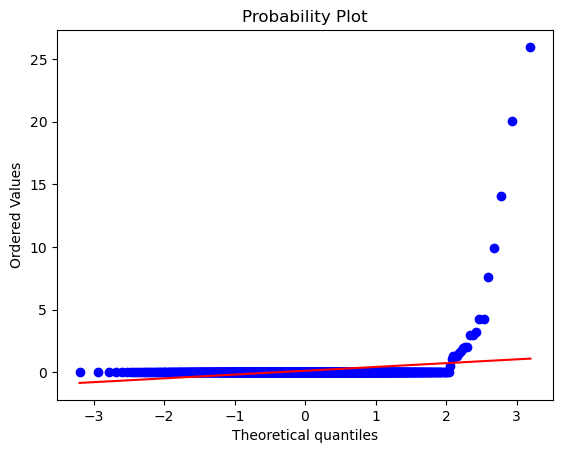

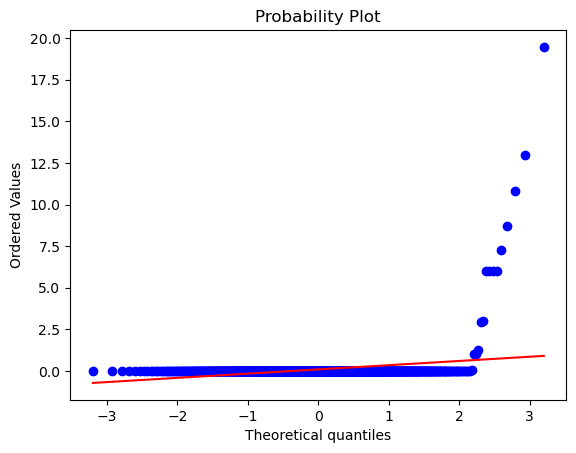

In [32]:
probplot(np.random.choice(control_revenue,1000), dist="norm",plot=plt)
plt.show()
probplot(np.random.choice(test_revenue,1000), dist="norm",plot=plt)
plt.show()

### Analysis Methods:

1. **Data Characteristics:**
   - The data is **not normally distributed**.
   - To assess the \( p \)-value:
     - Use the **Mann-Whitney test** (for comparing two samples).
     - Alternatively, use the **Bootstrap method** (more robust but computationally expensive).

2. **Method Selection:**
   - If the data shows a **right-hand tail** (a "shoulder" on the distribution), **Bootstrap** is recommended despite its computational cost.

#  Mann–Whitney U test 

In [25]:
u_stat, p_value = mannwhitneyu(control_revenue, test_revenue)

In [26]:
u_stat, p_value

(7882388.0, 0.5128877468183902)

### Results:

- The Mann-Whitney test results indicate that the distributions of the two samples are **identical**.
- Any observed differences between the groups are **not statistically significant at the 5% level**.

# Bootstrap test

In [27]:
np.random.seed(42)
n = 10000
control_means = np.random.choice(control_revenue, size=(n, len(control_revenue)), replace=True).mean(axis=1)
test_means = np.random.choice(test_revenue, size=(n, len(test_revenue)), replace=True).mean(axis=1)

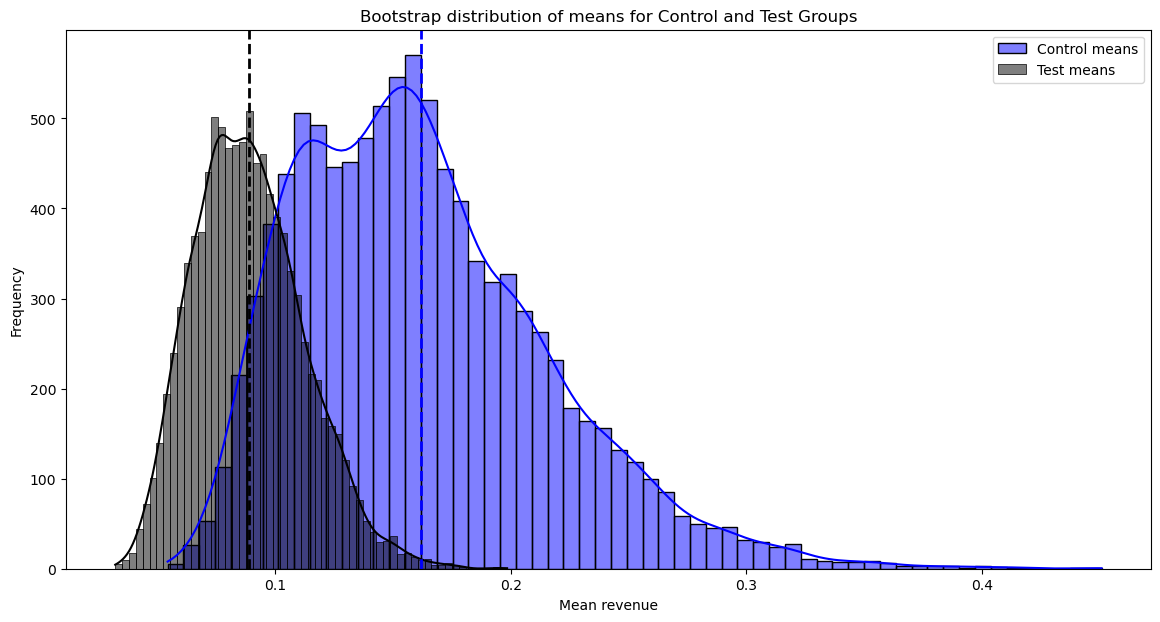

In [28]:
plt.figure(figsize=(14, 7))

sns.histplot(control_means, color='blue', kde=True, label='Control means')
sns.histplot(test_means, color='black', kde=True, label='Test means')

plt.axvline(control_revenue.mean(), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(test_revenue.mean(), color='black', linestyle='dashed', linewidth=2)
plt.legend()
plt.title('Bootstrap distribution of means for Control and Test Groups')
plt.xlabel('Mean revenue')
plt.ylabel('Frequency')
plt.show()

# Conclusions

In [29]:
control_mean = np.mean(control_means).round(2)
variant_mean = np.mean(test_means).round(2)
mann_whitney_p_value = p_value.round(2)

control_mean, variant_mean, mann_whitney_p_value

(0.16, 0.09, 0.51)

- The distributions of the two groups **overlap significantly**.
- This suggests that:
  - **The difference between group means is negligible.**
  - The effect of the introduced changes is **minimal**.